In [1]:
import sys
sys.path.append("../../")

from astronn.preprocess import prebedding
from astronn.datasets import bedding, starmodels
from astronn import models

import tensorflow as tf
#tf.compat.v1.disable_v2_behavior() 

import pandas as pd
import numpy as np
import shap
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.mixture import GaussianMixture

from collections import Counter

Using TensorFlow backend.


#### Preprocess is not needed if data exists in beforehand

In [2]:
# Preprocess bedding stars (only once)
if False:
    preprocessor = prebedding(conf_file="../../astronn/data/bedding/parameters.csv", cols=["tess", "dnu"])
    preprocessor.preprocess_files(
        input_folder="../data/bedding/raw/*",
        output_folder="../data/bedding/preprocessed/",
    )

#### Load bedding stars data

In [3]:
bedding_stars = bedding()
df_bedding = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=57)

##### Take and show one example

b'tess2018319095959-s0005-0000000044645679-0125-s_lc_det'
72.10648170223942
b'tess2018319095959-s0005-0000000034197596-0125-s_lc_det'
78.125
b'tess2018234235059-s0002-0000000327996759-0121-s_lc_det'
69.90740696589151
b'tess2018319095959-s0005-0000000242944780-0125-s_lc_det'
83.33333112575389
b'tess2018319095959-s0005-0000000348792358-0125-s_lc_det'
80.43981260723537
b'tess2018349182459-s0006-0000000011361473-0126-s_lc_det'
87.3842614668387
b'tess2018349182459-s0006-0000000037498433-0126-s_lc_det'
82.17592482213621
b'tess2018234235059-s0002-0000000327996759-0121-s_lc_det'
69.90740696589151
b'tess2019006130736-s0007-0000000112484997-0131-s_lc_det'
76.96759369638231
b'tess2019032160000-s0008-0000000176400189-0136-s_lc_det'
76.85185030654624
b'tess2019169103026-s0013-0000000269792989-0146-s_lc_det'
78.00925661016393
b'tess2018319095959-s0005-0000000255548143-0125-s_lc_det'
79.86111221490083
b'tess2019006130736-s0007-0000000112484997-0131-s_lc_det'
76.96759369638231
b'tess2018234235059-s000

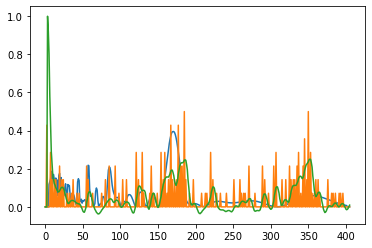

In [4]:
aux = None
for star in df_bedding.take(15):  # take the 1 bedding stars
    aux = star
    print(str(star[0].numpy()[0]))
    print(str(star[3].numpy()[0] / 0.0864)) # Show dnu in muHz from Bedding's paper
x = aux[1].numpy()

plt.plot(x[0, :, 0])
plt.plot(x[0, :, 1])
plt.plot(x[0, :, 2])
plt.show()

#### Utils functions

In [5]:
def normalize(x):
    """
    """
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Custom metrics
def top_2_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_4_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=4)

def top_6_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=6)

def top_8_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=8)

def calculate_shap_by_gradient(model, x_explain):
    """
    """
    e = shap.GradientExplainer(model, x_train, batch_size=1000, local_smoothing=0)
    shap_values, indexes = e.shap_values(x_explain, nsamples=10000, ranked_outputs=5)
    return shap_values, indexes

## Bedding 57 stars process

#### Read star models for Shap computation and load saved NN model

In [6]:
# Read datasets of preprocessed stars
bedding_stars = bedding()
df = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=1)
# Read star models (trainning) to calculate shap values
star_models = starmodels()
df_sm = star_models.load("/home/roberto/Downloads/dataall_parts/*", batch_size=150, add_noise=True)
_train_shap = np.asarray([line[0].numpy() for line in df_sm.take(10)])
_train_shap = _train_shap.reshape(
    (
        _train_shap.shape[0] * _train_shap.shape[1],
        _train_shap.shape[2],
        _train_shap.shape[3],
    )
)
number_shap_plots = 1

# Load model
sepconv_mod = tf.keras.models.load_model("/home/roberto/Projects/sepconvnn_tmp_400/")
sepconv_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 397, 10)           610       
_________________________________________________________________
batch_normalization (BatchNo (None, 397, 10)           40        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 198, 10)           0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 194, 10)           1510      
_________________________________________________________________
batch_normalization_1 (Batch (None, 194, 10)           40        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 97, 10)            0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 47, 10)            1

### NN inference on  bedding stars

In [7]:

# Shap explainer
e = shap.GradientExplainer(sepconv_mod, _train_shap, batch_size=10, local_smoothing=0)
# DS to save results
results = {}
# Loop over stars under study
count = 0
for star in df.take(57):  # take the 57 bedding stars
    if True:
        # Star channels info
        x_star = star[1].numpy()

        # Dnu NN inference
        dnu_hat = sepconv_mod.predict_classes(star[1])

        # Plot graphs and info (debug)
        if True:
            # Calculate gradient explainers and shap values
            shap_values, indexes = e.shap_values(
                star[1].numpy(), nsamples=100, ranked_outputs=40
            )

            # Log info
            print("Count: ", count)
            print("Star ID:", star[0].numpy()[0].decode("utf-8"))
            print("Shap values (sorted):", indexes)

            # Get top-k components
            #gmm = GaussianMixture(n_components=3).fit(indexes[0].reshape(-1, 1))
            #labels = gmm.predict(indexes[0].reshape(-1, 1))

            #def sort_dict(x):
            #    return {
            #        k: v
            #        for k, v in sorted(
            #            x.items(), key=lambda item: item[1], reverse=True
            #        )
            #    }

            #print("Top-k components")
            #topk_components = sort_dict(
            #    dict(zip([e[0] for e in gmm.means_], [e for e in gmm.weights_]))
            #)
            #print(topk_components)

            # Save results
            if star[0].numpy()[0].decode("utf-8") not in results:
                results[star[0].numpy()[0].decode("utf-8")] = {}
            results[star[0].numpy()[0].decode("utf-8")]["top-1"] = sepconv_mod.predict_classes(star[1])[0]
            #results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = list(topk_components)[0]
            #results[star[0].numpy()[0].decode("utf-8")]["top-k2"] = list(topk_components)[1]
            #results[star[0].numpy()[0].decode("utf-8")]["top-k3"] = list(topk_components)[2]
            results[star[0].numpy()[0].decode("utf-8")]["dnu"] = star[3].numpy()[0] / 0.0864
            results[star[0].numpy()[0].decode("utf-8")]["prob"] =  sepconv_mod.predict_proba(star[1])[0][sepconv_mod.predict_classes(star[1])[0]]

            probs = sepconv_mod.predict_proba(star[1])[0]
            peaks, _ = find_peaks(probs, height=0, distance=10)
            #plt.plot(probs)
            #plt.plot(peaks, probs[peaks], "x")
            #plt.plot(np.zeros_like(probs), "--", color="gray")
            #plt.show()
            peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
            # we skip the 0 beacuse is the first one
            #results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = np.where(probs==peaks_sorted_by_prob[0])[0][0]
            results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = np.where(probs==peaks_sorted_by_prob[1])[0][0]
            results[star[0].numpy()[0].decode("utf-8")]["top-k2"] = np.where(probs==peaks_sorted_by_prob[2])[0][0]
            results[star[0].numpy()[0].decode("utf-8")]["top-k3"] = np.where(probs==peaks_sorted_by_prob[3])[0][0]

            print(results[star[0].numpy()[0].decode("utf-8")])


            # Plot star
            if False:
                x = np.arange(-1, 100.5, 0.25)  # x axis from 0 to 100
                plt.plot(x, x_star[0, :, 0])
                plt.plot(x, x_star[0, :, 1])
                plt.plot(x, x_star[0, :, 2])
                plt.show()
                plt.plot(sepconv_mod.predict_proba(x_star)[0][0:100])
                plt.show()

                # Plot shap
                
                plt.plot(
                    x,
                    shap_values[0][0][:, [0]],
                    label="dft",
                    linestyle="solid",
                    color="blue",
                )
                plt.plot(
                    x,
                    shap_values[0][0][:, [1]],
                    label="hd",
                    linestyle="solid",
                    color="orange",
                )
                plt.plot(
                    x,
                    shap_values[0][0][:, [2]],
                    label="ac",
                    linestyle="solid",
                    color="green",
                )

                plt.legend(title="Channels")
                plt.show()
                
                print("\n")

    count += 1


m tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use `model.predict()` instead.
{'top-1': 38, 'dnu': 81.24999977924205, 'prob': 0.4613083, 'top-k1': 80, 'top-k2': 23, 'top-k3': 55, 'top-k4': 67, 'top-k5': 7}
Count:  1
Star ID: tess2018263035959-s0003-0000000159895674-0123-s_lc_det
Shap values (sorted): [[75 74 76 73 77 80 79 78 72 81 82 71 83 70 84 99 62 64 69 97 61 94 65 98
  85 63 37 54 57 68 66 55 38 95 96 39 60 59 36 92]]
{'top-1': 75, 'dnu': 79.39814969345375, 'prob': 0.3481277, 'top-k1': 62, 'top-k2': 97, 'top-k3': 37, 'top-k4': 87, 'top-k5': 48}
Count:  2
Star ID: tess2018319095959-s0005-0000000431695696-0125-s_lc_det
Shap values (sorted): [[83 41 42 40 84 82 43 39 85 38 81 44 86 87 46 80 45 37 69 88 47 57 68 70
  67 89 36 48 29 54 90 27 55 58 28 53 66 62 16 26]]
{'top-1': 83, 'dnu': 84.0277804268731, 'prob': 0.2407373, 'top-k1': 41, 'top-k2': 69, 'top-k3': 57, 'top-k4': 29, 'top-k5': 16}
Count:  3

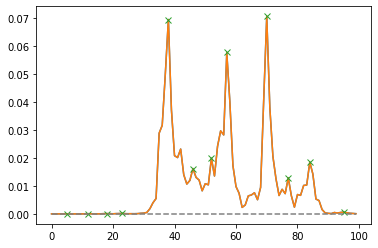

(array([38]),)

In [8]:
from scipy.signal import find_peaks
probs = sepconv_mod.predict_proba(star[1])[0]
plt.plot(probs)

peaks, _ = find_peaks(probs, height=0, distance=5)

plt.plot(probs)
plt.plot(peaks, probs[peaks], "x")
plt.plot(np.zeros_like(probs), "--", color="gray")
plt.show()

peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
np.where(probs==peaks_sorted_by_prob[1])


### Histogram of results for all stars (top-1)

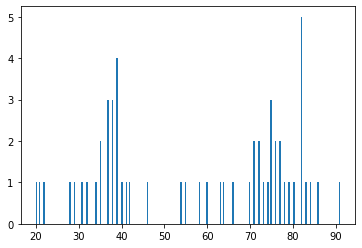

In [9]:
plt.hist([results[r]["top-1"] for r in results], bins=200)
plt.show()

In [10]:
df = pd.DataFrame.from_dict(results, orient="index")
df

,top-1,dnu,prob,top-k1,top-k2,top-k3,top-k4,top-k5
tess2019058134432-s0009-0000000463556278-0139-s_lc_det,38,81.250000,0.461308,80,23,55,67,7
tess2018263035959-s0003-0000000159895674-0123-s_lc_det,75,79.398150,0.348128,62,97,37,87,48
tess2018319095959-s0005-0000000431695696-0125-s_lc_det,83,84.027780,0.240737,41,69,57,29,16
tess2019058134432-s0009-0000000287347434-0139-s_lc_det,79,81.597224,0.358862,39,62,52,95,12
tess2018319095959-s0005-0000000100531058-0125-s_lc_det,39,79.861112,0.499816,82,22,62,49,7
tess2018319095959-s0005-0000000246902545-0125-s_lc_det,34,70.601851,0.398031,22,69,46,12,57
tess2018349182459-s0006-0000000117766204-0126-s_lc_det,76,75.694444,0.346560,38,62,22,50,12
tess2018234235059-s0002-0000000224284988-0121-s_lc_det,66,68.634257,0.200500,32,51,20,82,4
tess2018349182459-s0006-0000000124429243-0126-s_lc_det,78,74.074075,0.231704,38,55,22,7,90
tess2018349182459-s0006-0000000294157254-0126-s_lc_det,76,80.092593,0.240811,38,53,66,97,12


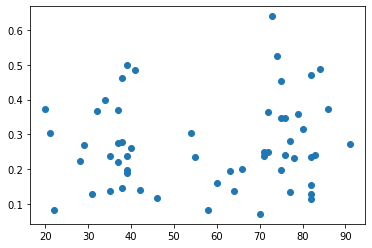

In [11]:
plt.scatter(df["top-1"], df["prob"])

In [12]:
inferences = [results[r]["top-1"] for r in results]
targets = [results[r]["dnu"] for r in results]
ids = results.keys()

Text(0, 0.5, 'NN Inference ($\\mu$Hz)')

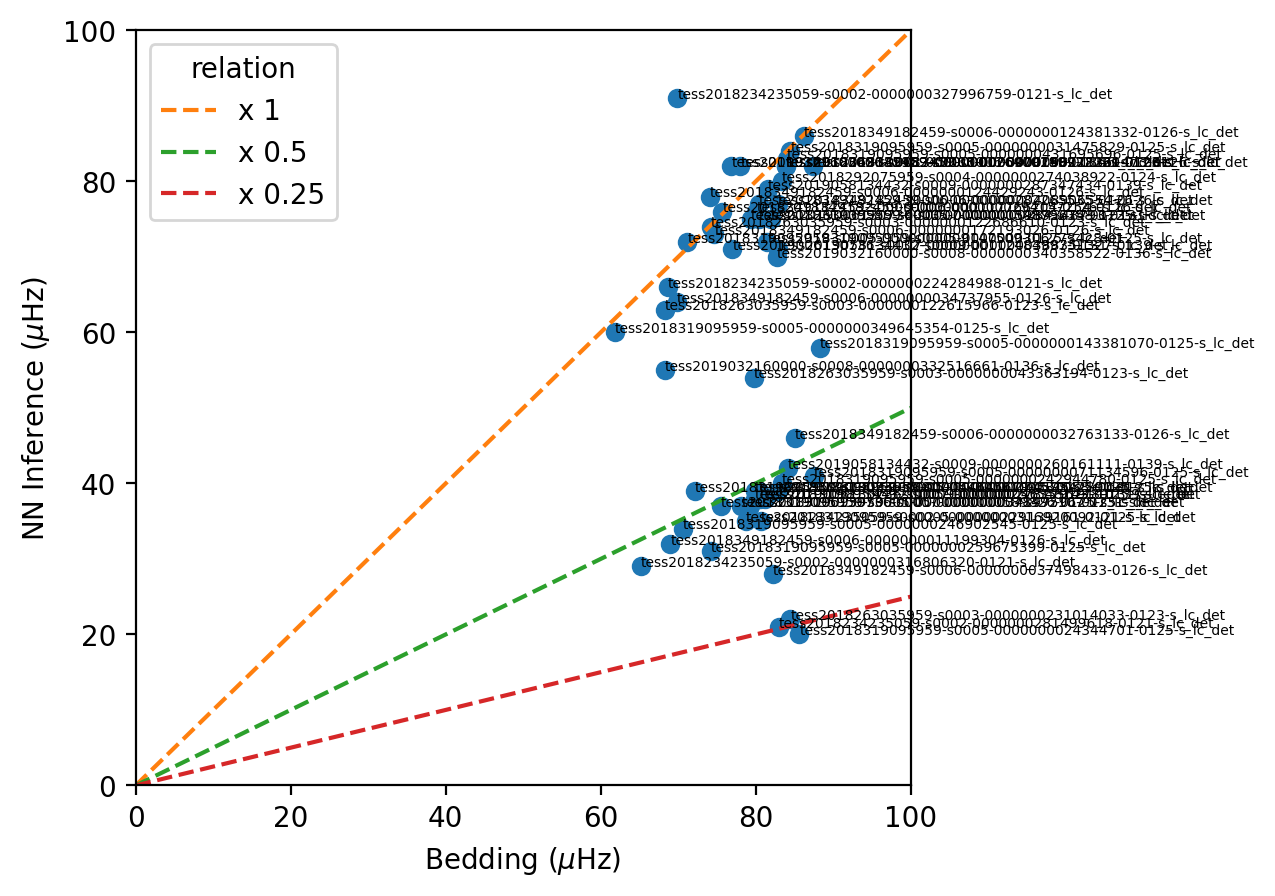

In [13]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', label="x "+str(slope))
    
# Set lims
plt.subplots(1, figsize=(5, 5), dpi=200)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.plot(targets, inferences, "o") # Plot relation
for i, txt in enumerate(ids):
    plt.annotate(txt, (targets[i], inferences[i]), size=5)

# Add multiple and submultiples
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
plt.legend(title="relation")
plt.xlabel("Bedding ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")

In [14]:
df.to_csv("/tmp/bedding_nn.csv.gz", index=True)

In [15]:
import numpy as np
len([e for e in np.unique([ee.split("-")[2] for ee in pd.read_csv('/tmp/bedding_nn.csv.gz', compression='gzip', header=0)["Unnamed: 0"]])])

57

In [16]:
np.unique([e.split("-")[0] for e in df.index])
len(df)
df

,top-1,dnu,prob,top-k1,top-k2,top-k3,top-k4,top-k5
tess2019058134432-s0009-0000000463556278-0139-s_lc_det,38,81.250000,0.461308,80,23,55,67,7
tess2018263035959-s0003-0000000159895674-0123-s_lc_det,75,79.398150,0.348128,62,97,37,87,48
tess2018319095959-s0005-0000000431695696-0125-s_lc_det,83,84.027780,0.240737,41,69,57,29,16
tess2019058134432-s0009-0000000287347434-0139-s_lc_det,79,81.597224,0.358862,39,62,52,95,12
tess2018319095959-s0005-0000000100531058-0125-s_lc_det,39,79.861112,0.499816,82,22,62,49,7
tess2018319095959-s0005-0000000246902545-0125-s_lc_det,34,70.601851,0.398031,22,69,46,12,57
tess2018349182459-s0006-0000000117766204-0126-s_lc_det,76,75.694444,0.346560,38,62,22,50,12
tess2018234235059-s0002-0000000224284988-0121-s_lc_det,66,68.634257,0.200500,32,51,20,82,4
tess2018349182459-s0006-0000000124429243-0126-s_lc_det,78,74.074075,0.231704,38,55,22,7,90
tess2018349182459-s0006-0000000294157254-0126-s_lc_det,76,80.092593,0.240811,38,53,66,97,12


In [17]:
df["TIC"] = (
    df.index.str.split("-", n=2, expand=False)
    .str[2]
    .str.split("-")
    .str[0]
    .astype(int)
    .astype(str)
)
df_att = pd.io.parsers.read_csv("../data/bedding/bedding.csv", sep=",", index_col=0)
df_joined = df.set_index("TIC").join(df_att.set_index("TIC"))
# Add flag
df_joined["abs_error"] = np.abs(df_joined["top-1"] - df_joined["dnu"])
df_joined["flag"] = df_joined["abs_error"] < 12
pd.set_option("display.max_columns", None)
df_joined

,top-1,dnu,prob,top-k1,top-k2,top-k3,top-k4,top-k5,HD,Name,V,Teff,L,e.L.,rho,e.rho.,Dnu,eps,vsini,e.vsini.,F0,abs_error,flag
TIC,,,,,,,,,,,,,,,,,,,,,,,
463556278,38,81.250000,0.461308,80,23,55,67,7,89263.0,HR4043,6.22,NaN,NaN,NaN,NaN,NaN,7.02,1.71,100.0,7.0,19.0242,43.250000,False
159895674,75,79.398150,0.348128,62,97,37,87,48,20232.0,NaN,6.88,8060.0,8.64,0.36,0.44,0.05,6.86,1.64,37.0,3.0,18.1104,4.398150,True
431695696,83,84.027780,0.240737,41,69,57,29,16,NaN,TYC 85-867-1,9.63,7961.0,8.85,0.57,0.40,0.05,7.26,1.61,NaN,NaN,18.9486,1.027780,True
287347434,79,81.597224,0.358862,39,62,52,95,12,99506.0,NaN,8.36,7970.0,7.58,0.37,0.48,0.05,7.05,1.59,26.0,2.0,18.2595,2.597224,True
100531058,39,79.861112,0.499816,82,22,62,49,7,38597.0,NaN,8.65,8430.0,10.38,0.47,0.44,0.05,6.90,1.68,150.0,40.0,18.4920,40.861112,False
246902545,34,70.601851,0.398031,22,69,46,12,57,31322.0,NaN,9.28,8260.0,13.19,0.67,0.32,0.04,6.10,1.69,200.0,50.0,16.4090,36.601851,False
117766204,76,75.694444,0.346560,38,62,22,50,12,45424.0,NaN,7.18,8060.0,10.39,0.44,0.36,0.04,6.54,1.86,NaN,NaN,18.7044,0.305556,True
224284988,66,68.634257,0.200500,32,51,20,82,4,223011.0,NaN,6.32,7830.0,10.49,0.44,0.31,0.04,5.93,1.68,NaN,NaN,15.8924,2.634257,True
124429243,78,74.074075,0.231704,38,55,22,7,90,42915.0,NaN,9.04,8520.0,12.82,0.68,0.38,0.05,6.40,NaN,118.0,5.0,NaN,3.925925,True


### Multilevel analisis

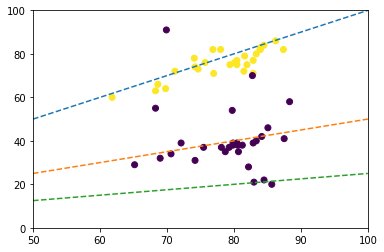

In [18]:
#df_joined = df_joined.drop("143381070")
#df_joined = df_joined.drop("332516661")
#df_joined = df_joined.drop("327996759")
#df_joined = df_joined.drop("43363194")
plt.scatter(df_joined["dnu"] , df_joined["top-1"], c=df_joined["flag"])
plt.xlim(50, 100)
plt.ylim(0, 100)
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       8.132
Link Function:                        LogitLink Log Likelihood:                                   -28.8776
Number of Samples:                           46 AIC:                                               74.0193
                                                AICc:                                              79.1785
                                                UBRE:                                               3.7505
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0943
Feature Function                  Lam

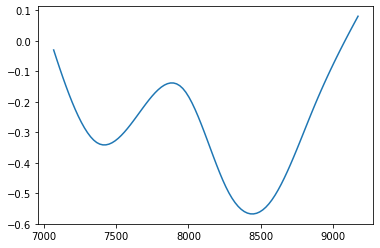

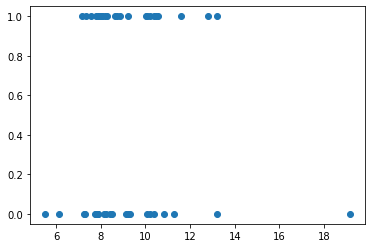

In [19]:
from pygam import LogisticGAM, LinearGAM, s, te
_x = df_joined[
    df_joined["L"].notna() & df_joined["Teff"].notna() & df_joined["V"].notna()
]
gam = LogisticGAM(s(0) + s(1) + s(2), n_splines=10)
gam.fit(_x[["L", "Teff", "V"]], _x["flag"])
gam.summary()

XX = gam.generate_X_grid(term=1)
plt.plot(XX[:, 1], gam.partial_dependence(term=1, X=XX))
plt.show()
plt.scatter(_x["L"], _x["flag"])

_x.to_csv("/home/roberto/bedding_joined.csv", index=True)

## Join Star models with ${\Delta\nu}_{bedding}$ and ${T_{eff}}_{bedding}$  

In [20]:
df_dnus = pd.read_csv("/tmp/files_dnus.csv",sep=",",header=0,  names=["file", "dnu"])
df_dnus.head()

,file,dnu
0,VO-m275fe0a164o0rotjpzt5p7-ad/00158-m275fe0a16...,5.118
1,VO-m260fe-3a164o0rotjpzt5p7-ad/00221-m260fe-3a...,4.787
2,VO-m275fe0a164o0rotjpzt5p7-ad/00415-m275fe0a16...,3.416
3,VO-m145fe-3a164o0rotjpzt5p5-ad/00960-m145fe-3a...,5.022
4,VO-m135fe010a164o00rotjpzt5p7-ad/00292-m135fe0...,7.687


In [21]:
with open(
    "/home/roberto/Projects/asteroseismologyNN/selected_models_preprocessed.csv", "w"
) as outfile:
    wr = csv.writer(outfile)
    wr.writerow(["xc", "l", "teff", "selected", "path"])
    with open(
        "/home/roberto/Projects/asteroseismologyNN/selected_models.csv", "r"
    ) as infile:
        for id, row in enumerate(infile):
            if id > 0:
                chunks = row.split(",")
                if len(chunks) == 8:
                    try:
                        aux = [
                            float(chunks[0] + "." + chunks[1]),
                            float(chunks[2] + "." + chunks[3]),
                            float(chunks[4] + "." + chunks[5]),
                            chunks[6],
                            chunks[7].replace('"', "").replace("\n", ""),
                        ]
                        wr.writerow(aux)
                    except:
                        aux = [
                            float(0.0),
                            float(0.0),
                            float(chunks[4] + "." + chunks[5]),
                            chunks[6],
                            chunks[7].replace('"', "").replace("\n", ""),
                        ]
                        wr.writerow(aux)

In [22]:
df_l_teff = pd.read_csv(
    "/home/roberto/Projects/asteroseismologyNN/selected_models_preprocessed.csv",
    sep=",",
    header=0,
    names=["xc", "l", "teff", "selected", "path"],
)
df_l_teff.head()
print(len(df_l_teff))

506784


In [23]:
df_dnu_l_teff = df_dnus.set_index("file").join(df_l_teff.set_index("path"))
df_dnu_l_teff["dnu"] = df_dnu_l_teff["dnu"] / 0.0864
df_dnu_l_teff.head()

,dnu,xc,l,teff,selected
file,,,,,
VO-m275fe0a164o0rotjpzt5p7-ad/00158-m275fe0a164o0rotjpzt5p7-ad.frq,59.236111,0.622402,52.276290,10643.345609,True
VO-m260fe-3a164o0rotjpzt5p7-ad/00221-m260fe-3a164o0rotjpzt5p7-ad.frq,55.405093,0.631469,36.650261,9763.029945,True
VO-m275fe0a164o0rotjpzt5p7-ad/00415-m275fe0a164o0rotjpzt5p7-ad.frq,39.537037,0.372260,63.041466,9777.683034,True
VO-m145fe-3a164o0rotjpzt5p5-ad/00960-m145fe-3a164o0rotjpzt5p5-ad.frq,58.125000,0.138201,4.259204,5961.591979,True
VO-m135fe010a164o00rotjpzt5p7-ad/00292-m135fe010a164o00rotjpzt5p7-ad.frq,88.969907,0.514600,3.247009,6456.429298,True


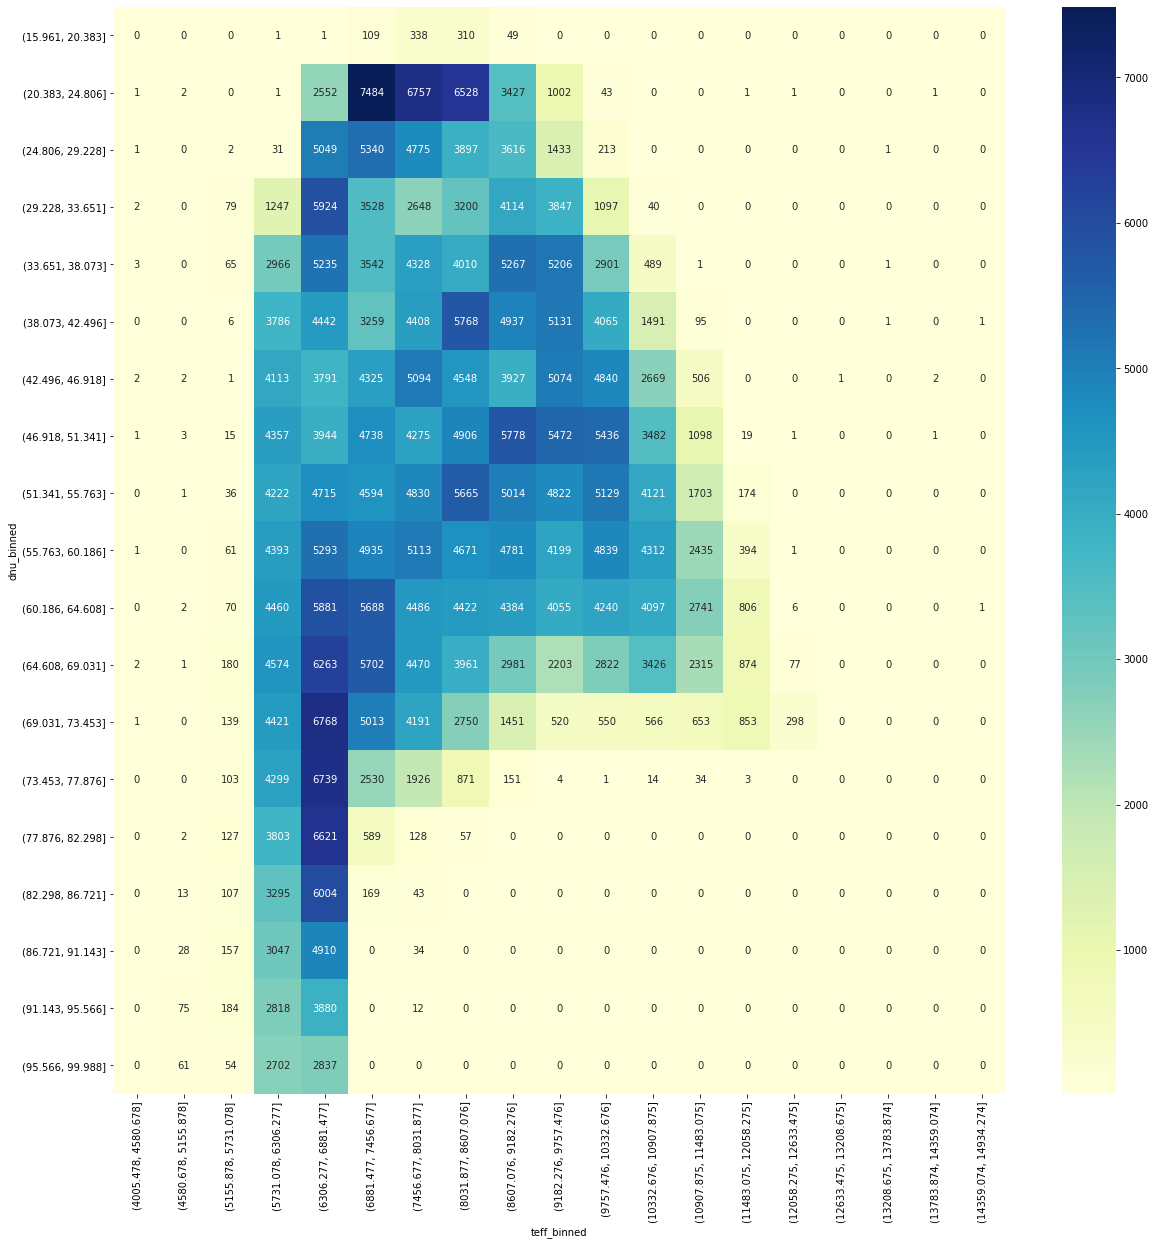

In [24]:
df_dnu_l_teff_filter = df_dnu_l_teff[
    (df_dnu_l_teff["dnu"] < 100) & (df_dnu_l_teff["dnu"] > 1)
]

df_dnu_l_teff_filter["dnu_binned"] = pd.cut(
    df_dnu_l_teff_filter["dnu"],
    np.linspace(
        df_dnu_l_teff_filter["dnu"].min(), df_dnu_l_teff_filter["dnu"].max(), 20
    ),
)
df_dnu_l_teff_filter["teff_binned"] = pd.cut(
    df_dnu_l_teff_filter["teff"],
    np.linspace(
        df_dnu_l_teff_filter["teff"].min(), df_dnu_l_teff_filter["teff"].max(), 20
    ),
)

df_grouped = (
    df_dnu_l_teff_filter.groupby(["dnu_binned", "teff_binned"]).size().unstack()
)
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(df_grouped, linewidth=0.0, annot=True, cmap="YlGnBu", fmt="d", vmin=10)
plt.show()

## Inclination angle

In [25]:
results = []
for index in range(len(df_joined)):
    flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index]["top-1"] - 1.0) & (
        df_dnu_l_teff["dnu"] <= df_joined.iloc[index]["top-1"] + 1.0
    )
    flag_teff = (
        df_dnu_l_teff["teff"]
        >= df_joined.iloc[index]["Teff"] - df_joined.iloc[index]["Teff"] * 0.01
    ) & (
        df_dnu_l_teff["teff"]
        <= df_joined.iloc[index]["Teff"] + df_joined.iloc[index]["Teff"] * 0.01
    )
    selected = df_dnu_l_teff[flag_dnu & flag_teff]["l"]
    if np.isnan(selected.mean()):
        results.append(np.nan)
    else:
        results.append(df_joined.iloc[index]["L"] > selected.quantile(0.1))

df_joined["inc_angle"] = results
df_joined.head(30)[["top-1", "L", "dnu", "inc_angle"]]
print(df_joined[["Teff", "L", "top-1", "dnu", "inc_angle", "flag"]].head(50))

results = []
inferences = []
for index in range(len(df_joined)):
    subresult = []
    for inference in ["top-1", "top-k1", "top-k2", "top-k3"]:
        flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index][inference] - 1.0) & (
            df_dnu_l_teff["dnu"] <= df_joined.iloc[index][inference] + 1.0
        )
        flag_teff = (
            df_dnu_l_teff["teff"]
            >= df_joined.iloc[index]["Teff"] - df_joined.iloc[index]["Teff"] * 0.2
        ) & (
            df_dnu_l_teff["teff"]
            <= df_joined.iloc[index]["Teff"] + df_joined.iloc[index]["Teff"] * 0.2
        )
        selected = df_dnu_l_teff[flag_dnu & flag_teff]["l"]
        if len(selected) < 5:
            subresult.append(np.nan)
        else:
            subresult.append(round(abs(df_joined.iloc[index]["L"]-selected.quantile(0.5)), 2))
    
    subresult.append(df_joined.iloc[index]["L"])
    results.append(subresult)

             Teff      L  top-1        dnu inc_angle   flag
TIC                                                        
463556278     NaN    NaN     38  81.250000       NaN  False
159895674  8060.0   8.64     75  79.398150     False   True
431695696  7961.0   8.85     83  84.027780       NaN   True
287347434  7970.0   7.58     79  81.597224     False   True
100531058  8430.0  10.38     39  79.861112     False  False
246902545  8260.0  13.19     34  70.601851     False  False
117766204  8060.0  10.39     76  75.694444      True   True
224284988  7830.0  10.49     66  68.634257      True   True
124429243  8520.0  12.82     78  74.074075      True   True
294157254  7650.0   7.80     76  80.092593      True   True
43363194   7930.0   7.86     54  79.745369     False  False
270577175  8080.0   8.49     39  80.439813     False  False
112484997  7800.0   8.06     71  76.967594     False   True
282265535  8700.0  10.58     77  80.439813     False   True
34737955   7320.0   7.17     64  69.7916

In [26]:
m = pd.DataFrame(np.asarray(results))
m.index = df_joined.index
m

,0,1,2,3,4
TIC,,,,,
463556278,NaN,NaN,NaN,NaN,NaN
159895674,3.41,2.63,5.56,20.48,8.64
431695696,4.89,15.73,1.25,4.25,8.85
287347434,3.22,18.64,3.04,8.83,7.58
100531058,23.04,5.90,33.39,3.40,10.38
246902545,24.60,30.11,4.71,8.76,13.19
117766204,5.46,18.04,0.88,32.78,10.39
224284988,2.07,13.57,5.68,43.15,10.49
124429243,7.75,23.23,5.49,31.30,12.82


In [27]:
def f(row):
    if np.isnan(row["inc_angle"]):
        val = 0
    else:
        val = 1
    return val
df_joined['drop'] = df_joined.apply(f, axis=1)

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.6986
Link Function:                     IdentityLink Log Likelihood:                                  -159.5785
Number of Samples:                           47 AIC:                                              328.5541
                                                AICc:                                             329.8507
                                                GCV:                                                0.1111
                                                Scale:                                              0.0955
                                                Pseudo R-Squared:                                   0.2102
Feature Function                  Lam

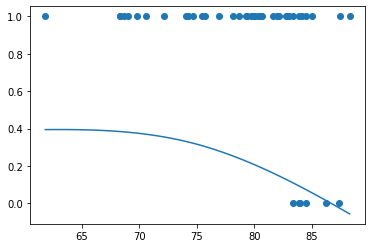

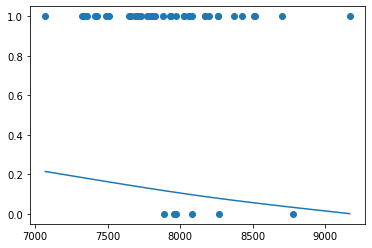

In [28]:
_x = df_joined[df_joined['Teff'].notna()]

gam = LinearGAM(s(0)+s(1), n_splines=5)
gam.fit(_x[["dnu","Teff"]], _x["drop"])
gam.summary()

XX = gam.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
plt.scatter(_x["dnu"], _x["drop"])
plt.show()

XX = gam.generate_X_grid(term=1)
plt.plot(XX[:, 1], gam.partial_dependence(term=1, X=XX))
plt.scatter(_x["Teff"], _x["drop"])

In [29]:
df_joined.groupby(["flag", "inc_angle"]).size().unstack(fill_value=0)

inc_angle,False,True
flag,,
False,23,1
True,9,8


Text(0, 0.5, 'NN Inference ($\\mu$Hz)')

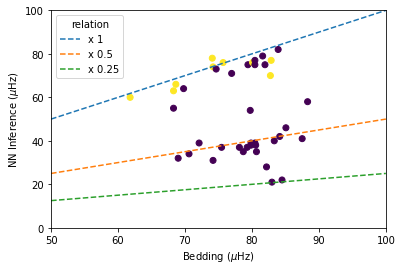

In [30]:
plt.scatter(df_joined["dnu"] , df_joined["top-1"], c=df_joined["inc_angle"])
plt.xlim(50, 100)
plt.ylim(0, 100)
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
plt.legend(title="relation")
plt.xlabel("Bedding ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                         2.0
Link Function:                        LogitLink Log Likelihood:                                   -21.8151
Number of Samples:                           40 AIC:                                               47.6303
                                                AICc:                                              48.2969
                                                UBRE:                                               3.2308
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2002
Feature Function                  Lam

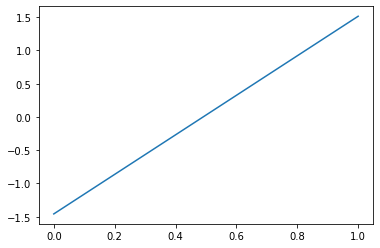

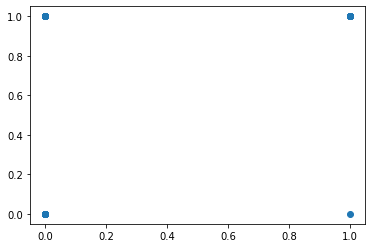

In [31]:
_x = df_joined[df_joined["inc_angle"].notna() & df_joined["L"].notna()]
gam = LogisticGAM(s(0))
gam.fit(_x[["inc_angle"]], _x["flag"])
gam.summary()

XX = gam.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
plt.show()
plt.scatter(_x["inc_angle"], _x["flag"])

_x.to_csv("/home/roberto/bedding_joined.csv", index=True)

## $T_{eff}$, L and $\Delta \nu$ star models match

In [32]:
results = []
for index in range(len(df_joined)):
    flag_dnu = (df_dnu_l_teff["dnu"] >= df_joined.iloc[index]["top-1"] - 1.0) & (
        df_dnu_l_teff["dnu"] <= df_joined.iloc[index]["top-1"] + 1.0
    )
    flag_teff = (
        df_dnu_l_teff["teff"]
        >= df_joined.iloc[index]["Teff"] - df_joined.iloc[index]["Teff"] * 0.02
    ) & (
        df_dnu_l_teff["teff"]
        <= df_joined.iloc[index]["Teff"] + df_joined.iloc[index]["Teff"] * 0.02
    )
    flag_l = (df_dnu_l_teff["l"] >= df_joined.iloc[index]["L"] - 3.0) & (
        df_dnu_l_teff["l"] <= df_joined.iloc[index]["L"] + 3.0
    )
    selected = df_dnu_l_teff[flag_dnu & flag_teff & flag_l]
    if np.isnan(df_joined.iloc[index]["L"]):
        results.append(np.nan)
    else:
        results.append(len(selected) > 0)

df_joined["star_match"] = results
print(
    df_joined[["Teff", "L", "top-1", "dnu", "inc_angle", "flag", "star_match"]].head(50)
)

             Teff      L  top-1        dnu inc_angle   flag star_match
TIC                                                                   
463556278     NaN    NaN     38  81.250000       NaN  False        NaN
159895674  8060.0   8.64     75  79.398150     False   True       True
431695696  7961.0   8.85     83  84.027780       NaN   True      False
287347434  7970.0   7.58     79  81.597224     False   True       True
100531058  8430.0  10.38     39  79.861112     False  False      False
246902545  8260.0  13.19     34  70.601851     False  False      False
117766204  8060.0  10.39     76  75.694444      True   True       True
224284988  7830.0  10.49     66  68.634257      True   True       True
124429243  8520.0  12.82     78  74.074075      True   True       True
294157254  7650.0   7.80     76  80.092593      True   True       True
43363194   7930.0   7.86     54  79.745369     False  False      False
270577175  8080.0   8.49     39  80.439813     False  False      False
112484

star_match  False  True 
flag                    
False          21      2
True            6     17


Text(0, 0.5, 'NN Inference ($\\mu$Hz)')

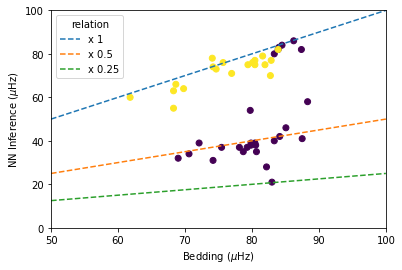

In [33]:
print(df_joined.groupby(["flag", "star_match"]).size().unstack(fill_value=0))

plt.scatter(df_joined["dnu"] , df_joined["top-1"], c=df_joined["star_match"])
plt.xlim(50, 100)
plt.ylim(0, 100)
abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
plt.legend(title="relation")
plt.xlabel("Bedding ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")

## Get L from adjusted GAM model

In [34]:
df_grouped.head(30).stack()[:3]

dnu_binned        teff_binned         
(15.961, 20.383]  (4005.478, 4580.678]    0
                  (4580.678, 5155.878]    0
                  (5155.878, 5731.078]    0
dtype: int64

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     40.7627
Link Function:                     IdentityLink Log Likelihood:                              -1004296.1428
Number of Samples:                       494768 AIC:                                          2008675.8111
                                                AICc:                                         2008675.8183
                                                GCV:                                                2.4836
                                                Scale:                                              2.4832
                                                Pseudo R-Squared:                                   0.9953
Feature Function                  Lam

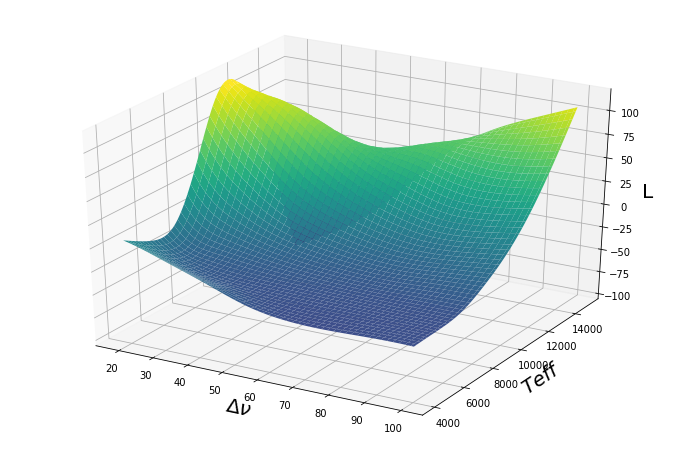

In [35]:
_x = df_dnu_l_teff_filter[df_dnu_l_teff_filter['l'].notna()]

gam = LinearGAM(te(0,1, n_splines=10))
gam.fit(_x[["dnu","teff"]], _x["l"])
gam.summary()

#XX = gam.generate_X_grid(term=0)
#plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
#plt.scatter(_x["teff"], _x["l"])
#plt.show()

XX = gam.generate_X_grid(term=0, meshgrid=True)
Z = gam.partial_dependence(term=0, X=XX, meshgrid=True)

plt.ion()
plt.rcParams['figure.figsize'] = (12, 8)
ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
ax.set_xlabel('$\Delta\\nu$', fontsize=20)
ax.set_ylabel('$Teff$', fontsize=20)
ax.set_zlabel('L', fontsize=20)
plt.show()

In [36]:
_x.loc[_x['l'] > 14]

,dnu,xc,l,teff,selected,dnu_binned,teff_binned
file,,,,,,,
VO-m275fe0a164o0rotjpzt5p7-ad/00158-m275fe0a164o0rotjpzt5p7-ad.frq,59.236111,0.622402,52.276290,10643.345609,True,"(55.763, 60.186]","(10332.676, 10907.875]"
VO-m260fe-3a164o0rotjpzt5p7-ad/00221-m260fe-3a164o0rotjpzt5p7-ad.frq,55.405093,0.631469,36.650261,9763.029945,True,"(51.341, 55.763]","(9757.476, 10332.676]"
VO-m275fe0a164o0rotjpzt5p7-ad/00415-m275fe0a164o0rotjpzt5p7-ad.frq,39.537037,0.372260,63.041466,9777.683034,True,"(38.073, 42.496]","(9757.476, 10332.676]"
VO-m260fe-3a164o0rotjpzt5p7-ad/00550-m260fe-3a164o0rotjpzt5p7-ad.frq,36.655093,0.352445,44.280384,8839.271588,True,"(33.651, 38.073]","(8607.076, 9182.276]"
VO-m275fe0a164o0rotjpzt5p7-ad/00214-m275fe0a164o0rotjpzt5p7-ad.frq,54.942130,0.575809,54.269239,10484.542547,True,"(51.341, 55.763]","(10332.676, 10907.875]"
...,...,...,...,...,...,...,...
VO-m260fe010a164o00rotjpzt5p5-ad/00513-m260fe010a164o00rotjpzt5p5-ad.frq,27.280093,0.177637,59.154352,8769.999920,True,"(24.806, 29.228]","(8607.076, 9182.276]"
VO-m260fe010a164o00rotjpzt5p5-ad/00272-m260fe010a164o00rotjpzt5p5-ad.frq,49.108796,0.498913,49.163884,10031.702914,True,"(46.918, 51.341]","(9757.476, 10332.676]"
VO-m260fe010a164o00rotjpzt5p5-ad/00455-m260fe010a164o00rotjpzt5p5-ad.frq,34.027778,0.275561,56.846362,9196.733866,True,"(33.651, 38.073]","(9182.276, 9757.476]"


In [45]:
tops = []
for index in range(len(df_joined)):
    subtops = []
    subtops.append(df_joined.iloc[index]["top-1"])
    subtops.append(df_joined.iloc[index]["top-k1"])
    subtops.append(df_joined.iloc[index]["top-k2"])
    subtops.append(df_joined.iloc[index]["top-k3"])
    tops.append(subtops)
tops = pd.DataFrame(np.asarray(tops))
tops

,0,1,2,3,4,5
0,38,80,23,55,67,7
1,75,62,97,37,87,48
2,83,41,69,57,29,16
3,79,39,62,52,95,12
4,39,82,22,62,49,7
5,34,22,69,46,12,57
6,76,38,62,22,50,12
7,66,32,51,20,82,4
8,78,38,55,22,7,90
9,76,38,53,66,97,12


In [46]:
corrected = []
for index in range(len(df_joined)):
    # print(df_joined.iloc[index][["dnu", "Teff", "L", "top-1", "top-k1", "top-k2", "top-k3"]])
    l = df_joined.iloc[index][["L"]][0]

    if not np.isnan(l):
        l_top1 = round(
            gam.predict(
                df_joined.iloc[index][["top-1", "Teff"]].to_numpy().reshape(1, 2)
            )[0],
            2,
        )
        l_topk1 = round(
            gam.predict(
                df_joined.iloc[index][["top-k1", "Teff"]].to_numpy().reshape(1, 2)
            )[0],
            2,
        )
        l_topk2 = round(
            gam.predict(
                df_joined.iloc[index][["top-k2", "Teff"]].to_numpy().reshape(1, 2)
            )[0],
            2,
        )
        l_topk3 = round(
            gam.predict(
                df_joined.iloc[index][["top-k3", "Teff"]].to_numpy().reshape(1, 2)
            )[0],
            2,
        )

        errors = [
            round(np.power(l_top1 - l, 2), 2),
            round(np.power(l_topk1 - l, 2), 2),
            round(np.power(l_topk2 - l, 2), 2),
            round(np.power(l_topk3 - l, 2), 2),
        ]
        # print(errors)
        corrected.append(tops.iloc[index][errors.index(min(errors))])
    else:
        corrected.append(np.nan)

                 dnu  corrected
TIC                            
463556278  81.250000        NaN
159895674  79.398150       75.0
431695696  84.027780       83.0
287347434  81.597224       79.0
100531058  79.861112       82.0
246902545  70.601851       69.0
117766204  75.694444       76.0
224284988  68.634257       66.0
124429243  74.074075       78.0
294157254  80.092593       76.0
43363194   79.745369       78.0
270577175  80.439813       72.0
112484997  76.967594       82.0
282265535  80.439813       77.0
34737955   69.791669       88.0
408906554  82.870369       77.0
284348793  81.944444       75.0
316806320  65.162038        NaN
143381070  88.310187       71.0
44645679   72.106482       80.0
122686610  74.189813       94.0
260161111  84.143518       84.0
150272131  83.912037       82.0
349645354  61.805557       60.0
176400189  76.851850        NaN
229139161  78.703706       81.0
11199304   68.981482       67.0
242944780  83.333331       82.0
332516661  68.287038       70.0
34197596

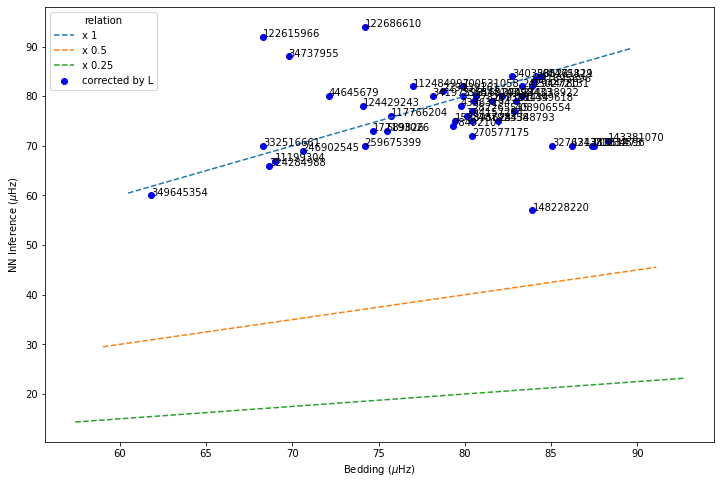

In [50]:
df_joined["corrected"] = corrected
print(df_joined[["dnu", "corrected"]])

fig, ax = plt.subplots()
ax.scatter(df_joined["dnu"], df_joined["corrected"], c="blue", label="corrected by L")
ax.scatter(df_joined["dnu"], df_joined["top-1"], c="red", label="top-1")
n = df_joined.index

for i, txt in enumerate(n):
    ax.annotate(txt, (df_joined.iloc[i][["dnu"]], df_joined.iloc[i][["corrected"]]))

abline(1, 0)
abline(0.5, 0)
abline(0.25, 0)
plt.legend(title="relation")
plt.xlabel("Bedding ($\mu$Hz)")
plt.ylabel("NN Inference ($\mu$Hz)")
plt.show()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      2.3894
Link Function:                     IdentityLink Log Likelihood:                                  -205.1304
Number of Samples:                           46 AIC:                                              417.0398
                                                AICc:                                             417.7548
                                                GCV:                                               37.4925
                                                Scale:                                              34.004
                                                Pseudo R-Squared:                                   0.0869
Feature Function                  Lam

[<matplotlib.lines.Line2D at 0x7fe3fc1aaf10>]

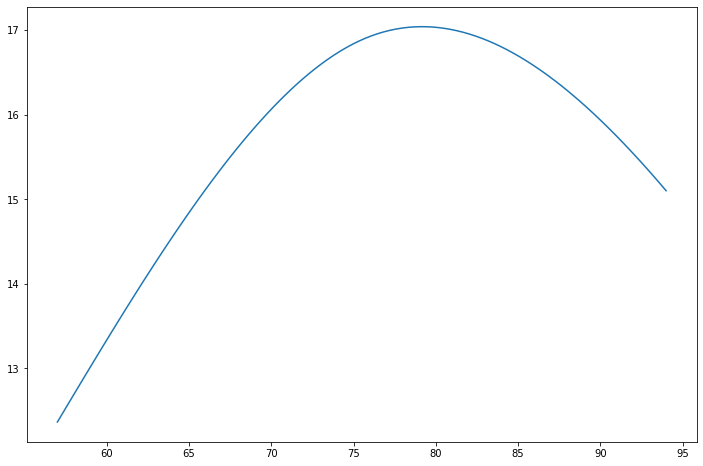

In [48]:
_x = df_joined[df_joined['corrected'].notna()]

gam2 = LinearGAM(s(0, n_splines=5))
gam2.fit(_x[["corrected"]], _x["dnu"])
gam2.summary()

XX = gam2.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam2.partial_dependence(term=0, X=XX))

46


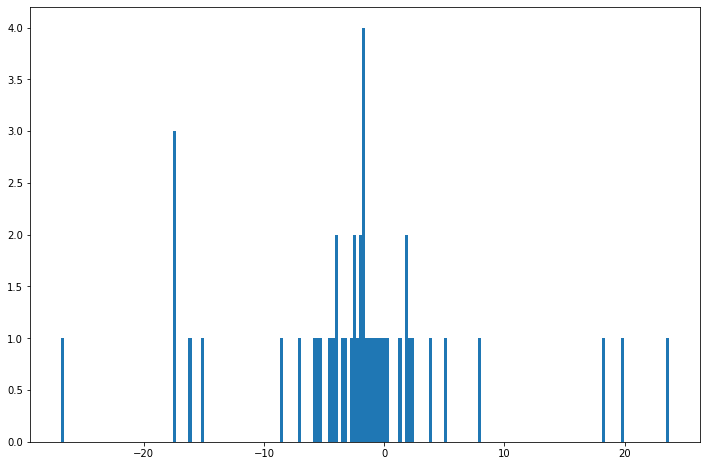

In [49]:
print(len(_x))
plt.hist(_x["corrected"] - _x["dnu"], bins=200)
plt.show()